In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px

import plotly.graph_objects as go
import json

In [38]:
# ========================================
# 1. LOAD TEXAS COUNTY BOUNDARIES
# ========================================

url = "https://www2.census.gov/geo/tiger/TIGER2025/COUNTY/tl_2025_us_county.zip"
counties = gpd.read_file(url)

# Filter to Texas only (FIPS code 48)
texas_counties = counties[counties['STATEFP'] == '48'].copy()

print(f"Loaded {len(texas_counties)} Texas counties")
print(texas_counties.head())

Loaded 254 Texas counties
   STATEFP COUNTYFP  COUNTYNS  GEOID         GEOIDFQ      NAME  \
3       48      377  01383974  48377  0500000US48377  Presidio   
5       48      489  01384030  48489  0500000US48489   Willacy   
10      48      427  01383999  48427  0500000US48427     Starr   
25      48      009  01383790  48009  0500000US48009    Archer   
26      48      023  01383797  48023  0500000US48023    Baylor   

           NAMELSAD LSAD CLASSFP  MTFCC CSAFP CBSAFP METDIVFP FUNCSTAT  \
3   Presidio County   06      H1  G4020  None   None     None        A   
5    Willacy County   06      H1  G4020   154  39700     None        A   
10     Starr County   06      H1  G4020   365  40100     None        A   
25    Archer County   06      H1  G4020  None  48660     None        A   
26    Baylor County   06      H1  G4020  None   None     None        A   

         ALAND     AWATER     INTPTLAT      INTPTLON  \
3   9985057447    1773188  +30.0058912  -104.2616192   
5   1529680719  5028

In [ ]:
# Data in csv from https://earlyvoting.texas-election.com/Elections/getElectionEVDates.do for 2024 November General election, Official Election Day turnout by 
# land area from https://www.texascounties.net/statistics/landarea.htm
# population https://www2.census.gov/programs-surveys/popest/tables/2020-2024/counties/totals/co-est2024-pop-48.xlsx

# ========================================
# 2. PREPARE DATA
# ========================================
voter_data = pd.read_csv('data/texas_voter_density.csv')

voter_data.columns = [
    'county_name',
    'registered_voters',
    'number_in_person_on_20241105',
    'cumulative_in_person_voters',
    'cumulative_percent_in_person',
    'cumulative_by_mail',
    'cumulative_in_person_and_mail',
    'voter_turnout',
    'land_area_sq_miles',
    'population_density',
    'total_area_sq_miles',
    'total_population'
]

numeric_columns = [
    'registered_voters',
    'number_in_person_on_20241105',
    'cumulative_in_person_voters',
    'cumulative_by_mail',
    'cumulative_in_person_and_mail',
    'land_area_sq_miles',
    'total_area_sq_miles',
    'total_population',
]
# Remove commas and convert to integers
for col in numeric_columns:
    voter_data[col] = voter_data[col].str.replace(',', '').astype(float)

# Handle percentage columns (remove % sign if present)
if voter_data['cumulative_percent_in_person'].dtype == 'object':
    voter_data['cumulative_percent_in_person'] = (
        voter_data['cumulative_percent_in_person']
        .str.replace('%', '')
        .astype(float)
    )
if voter_data['voter_turnout'].dtype == 'object':
    voter_data['voter_turnout'] = (
        voter_data['voter_turnout']
        .str.replace('%', '')
        .astype(float)
    )


voter_data['voter_density'] = voter_data['cumulative_in_person_and_mail']/voter_data['land_area_sq_miles']
voter_data['voter_percent'] = 100*voter_data['cumulative_in_person_and_mail']/voter_data['total_population']

# Merge with geographic data
texas_counties = texas_counties.merge(
    voter_data, 
    left_on='NAME', 
    right_on='county_name', 
    how='left'
)

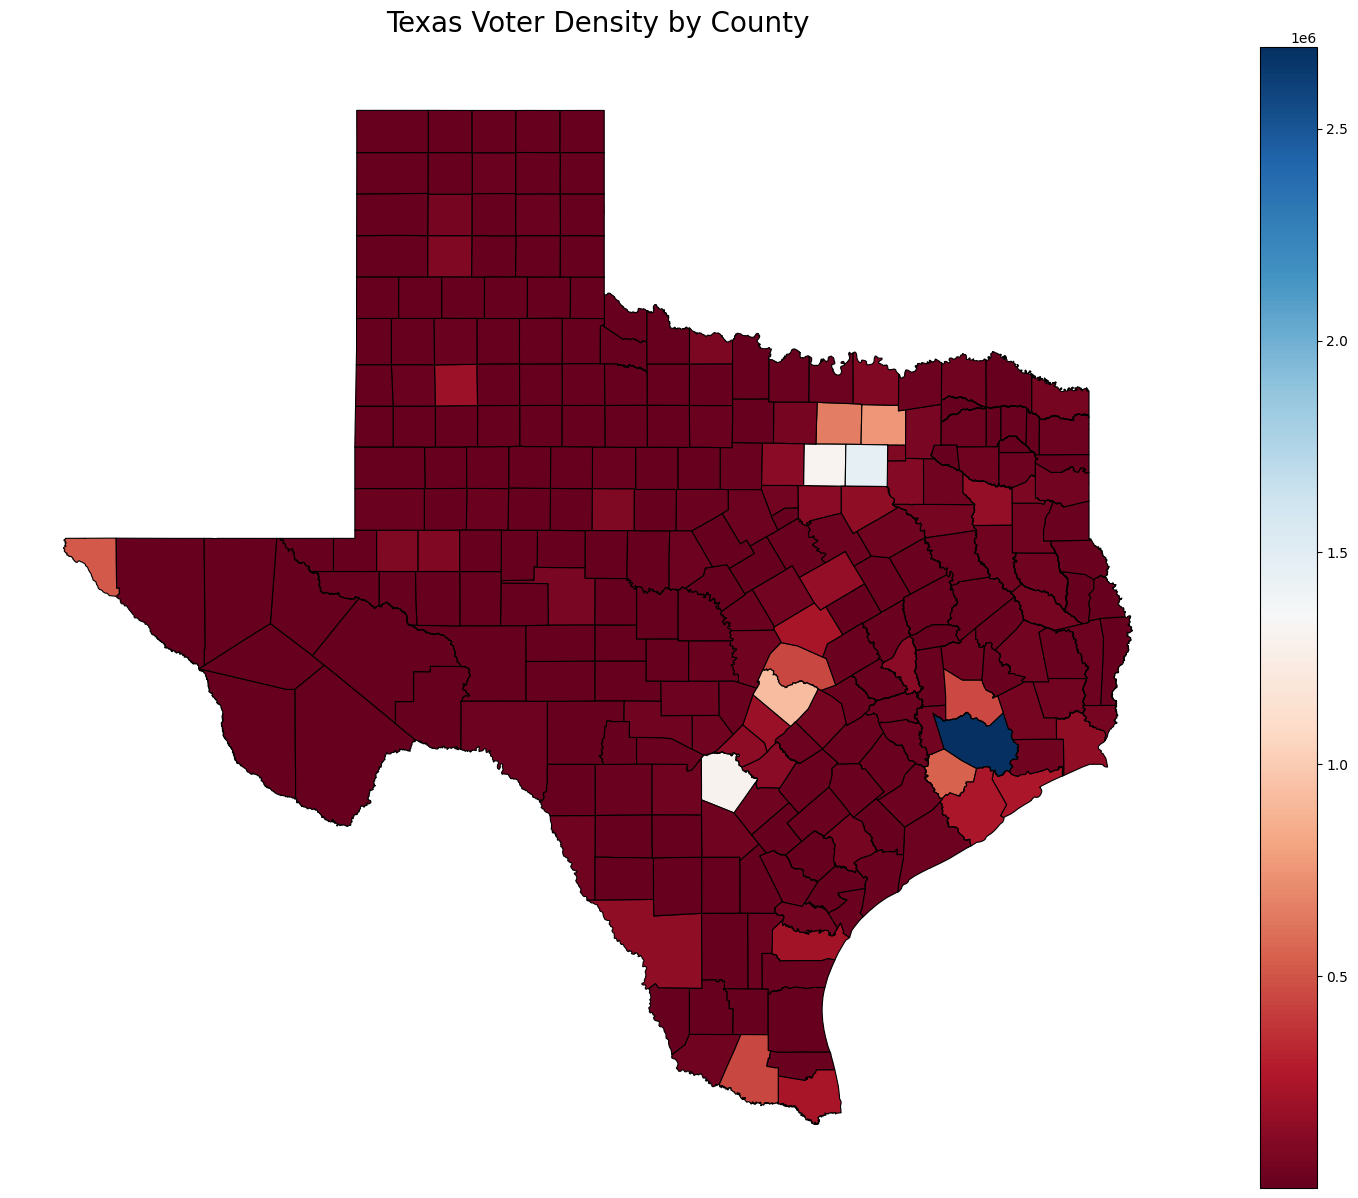

In [40]:
# ========================================
# 3. CREATE STATIC HEATMAP (for PDF)
# ========================================

fig, ax = plt.subplots(1, 1, figsize=(15, 12))

texas_counties.plot(
    column='registered_voters',
    cmap='RdBu',  # Yellow-Orange-Red colormap
    linewidth=0.8,
    edgecolor='black',
    legend=True,
    ax=ax,
    missing_kwds={'color': 'lightgrey'}  # Counties without data
)

ax.set_title('Texas Voter Density by County', fontsize=20, pad=20)
ax.axis('off')

# Save as PDF
plt.tight_layout()
plt.savefig('outputs/texas_voter_density.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# ========================================
# 4. CREATE INTERACTIVE MAP (with hover)
# ========================================
texas_counties_json = json.loads(texas_counties.to_json())
fig = px.choropleth(
    texas_counties,
    geojson=texas_counties_json,
    locations='GEOID',
    featureidkey='properties.GEOID',
    color='voter_density',
    hover_name='county_name',
    hover_data={
        'total_population': ':,.0f',
        'registered_voters': ':,.0f',
        'cumulative_in_person_and_mail': ':,.0f',
        'voter_density': ':.2f', 
        'land_area_sq_miles': ':,.0f',
        'GEOID': False},
    color_continuous_scale='YlOrRd',
    title='Texas Voter Information by County',
    labels={
        'total_population': 'Population',
        'registered_voters': 'Registered Voters',
        'cumulative_in_person_and_mail': 'Voters',
        'voter_density': 'Voter Density',
        'land_area_sq_miles': 'Land area (mi^2)',    
    }
)

fig.update_geos(
    fitbounds="locations",
    visible=False,
    center=dict(lat=31.5, lon=-99.5),  # Center of Texas
    projection_scale=5  # Zoom in on Texas
)

fig.update_layout(
    height=700, 
    width=1000,
    margin={"r":0,"t":50,"l":0,"b":0}
)

# Save as HTML (interactive with hover)
fig.write_html('outputs/texas_voter_density_interactive.html')


#for debug
# fig.show()

In [49]:
texas_counties.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'GEOID', 'GEOIDFQ', 'NAME',
       'NAMELSAD', 'LSAD', 'CLASSFP', 'MTFCC', 'CSAFP', 'CBSAFP', 'METDIVFP',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'county_name', 'registered_voters', 'number_in_person_on_20241105',
       'cumulative_in_person_voters', 'cumulative_percent_in_person',
       'cumulative_by_mail', 'cumulative_in_person_and_mail', 'voter_turnout',
       'land_area_sq_miles', 'population_density', 'total_area_sq_miles',
       'total_population', 'voter_density', 'voter_percent'],
      dtype='object')